# **Entraînement et évaluation des modèles**

# Pipeline d'entraînement et d'évaluation

Nous généralisons la fonction **`kfold_lightgbm`** du noyau de référence sur Kaggle, qui nous a largement inspirés. L'auteur de ce noyau de référence : https://www.kaggle.com/code/jsaguiar

Cela donne notre fonction chapeau **`home_credit.model.train.train_and_eval_pipeline`** qui s'appuie sur des fonctions et des structures auxiliaires pour permettre la lisibilité et la maintenabilité du code.

Dans cette généralisation, nous apportons les éléments suivants :
* passage du classifieur en paramètre (généralisation), pour être en mesure de réaliser notre benchmark,
* échantillonnage qui rééquilibre les deux classes, avec un paramètre pour passer un sampler `imblearn` paramétré avec une stratégie,
* normalisation des données à l'aide d'un *scaler* également passé en paramètre
* passage d'une fonction de perte *métier* spécifique en remplacement de l'AUC ROC par défaut
* ajout de mesures supplémentaires pour mettre en évidence les performances : on commence avec un F beta score avec un beta >= 1 pour favoriser la précision sur le rappel (les faux positifs sont préférables sur les faux négatifs, il s'agit donc de favoriser le score de précision sur le score de rappel par rapport au score F1 (F beta avec beta=1))
* retour d'un dictionnaire comprenant :
    * la prédiction sur le jeu de test
    * l'importance des catactéristiques
    * chacun des scores, par fold et global, pour chacune des mesures : AUC ROC, Fbeta, etc
* Externalisation pour un traitement spécifiques et optionnel:
    * de l'enregistrement et de la soumission des prédictions sur le jeu de test,
    * des affichages : les rapport graphiques
    * qui seront produits par des fonctions ad hoc sur la base des résultats produits par cette fonction.

# Isofonctionnalité avec `lightgbm_kernel.kfold_lightgbm`

Testons cette fonction à périmètre fonctionnel constant, de sorte à obtenir les mêmes résultats qu'avec `kfold_lightgbm` sur un échantillon de $10\,000$ individus.

In [ ]:
from home_credit.load import load_prep_dataset
data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)
display(data.head(1))

## Entraînement

<mark>**TODO** Améliorer les traces (post soutenance)</mark>

In [ ]:
from home_credit.best_model_search import kfold_train_and_eval_model
from home_credit.old_kernel_v2 import get_opt_lgbm_classifier
clf = get_opt_lgbm_classifier()
res = kfold_train_and_eval_model(
    data, clf, imb_sampler=None, scaler=None,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


LGBMClassifier(callbacks=None, colsample_bytree=0.9497036, learning_rate=0.02,
               max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 



'You should consider to pass a `imblearn` resampler through the `imb_sampler` parameter.'


Train vs. test subsets shapes
	Train shape: (8605, 788)
	Test shape: (1395, 788)

Evaluate the 1-th fold (on 5)
[200]	training's binary_logloss: 0.209714	valid_1's binary_logloss: 0.247878
Fold  0 F2: 0.000000
Fold  0 AUC: 0.730760

Evaluate the 2-th fold (on 5)
[200]	training's binary_logloss: 0.213283	valid_1's binary_logloss: 0.234768
[400]	training's binary_logloss: 0.186137	valid_1's binary_logloss: 0.2357
Fold  1 F2: 0.019231
Fold  1 AUC: 0.759607

Evaluate the 3-th fold (on 5)
[200]	training's binary_logloss: 0.20929	valid_1's binary_logloss: 0.253238
Fold  2 F2: 0.008787
Fold  2 AUC: 0.750649

Evaluate the 4-th fold (on 5)
[200]	training's binary_logloss: 0.209543	valid_1's binary_logloss: 0.25362
[400]	training's binary_logloss: 0.18269	valid_1's binary_logloss: 0.256464
Fold  3 F2: 0.000000
Fold  3 AUC: 0.746350

Evaluate the 5-th fold (on 5)
[200]	training's binary_logloss: 0.210569	valid_1's binary_logloss: 0.244876
[400]	training's binary_logloss: 0.18439	valid_1's binary

## Extraction des résultats

In [ ]:
resamples = res["resamples"]
preds = res["preds"]
scores = res["scores"]
feat_imps = res["feat_imps"]

X_train = resamples["X_train"]
X_test = resamples["X_test"]
y_train = resamples["y_train"]

train_preds = preds["train"]
test_preds = preds["test"]

train_pred_proba = train_preds["proba"]
train_pred_discr = train_preds["discr"]

test_pred_proba = test_preds["proba"]
test_pred_discr = test_preds["discr"]

## Interprétation des résultats

La classe minoritaire est prédite dans moins de $0.5\,\%$ des cas sur le jeu d'entraînement et jamais sur le jeu de test : c'est une conséquence directe du déséquilibre de classes!

In [ ]:
import numpy as np
display(train_pred_proba)
display(np.unique(train_pred_discr, return_counts=True))
display(test_pred_proba)
display(np.unique(test_pred_discr, return_counts=True))

array([0.01886309, 0.03073775, 0.01901879, ..., 0.01865922, 0.02502743,
       0.07552042])

(array([0., 1.]), array([8600,    5], dtype=int64))

array([0.03385028, 0.22384651, 0.04483355, ..., 0.07596373, 0.0500324 ,
       0.18335337])

(array([0.]), array([1395], dtype=int64))

## Importance des caractéristiques

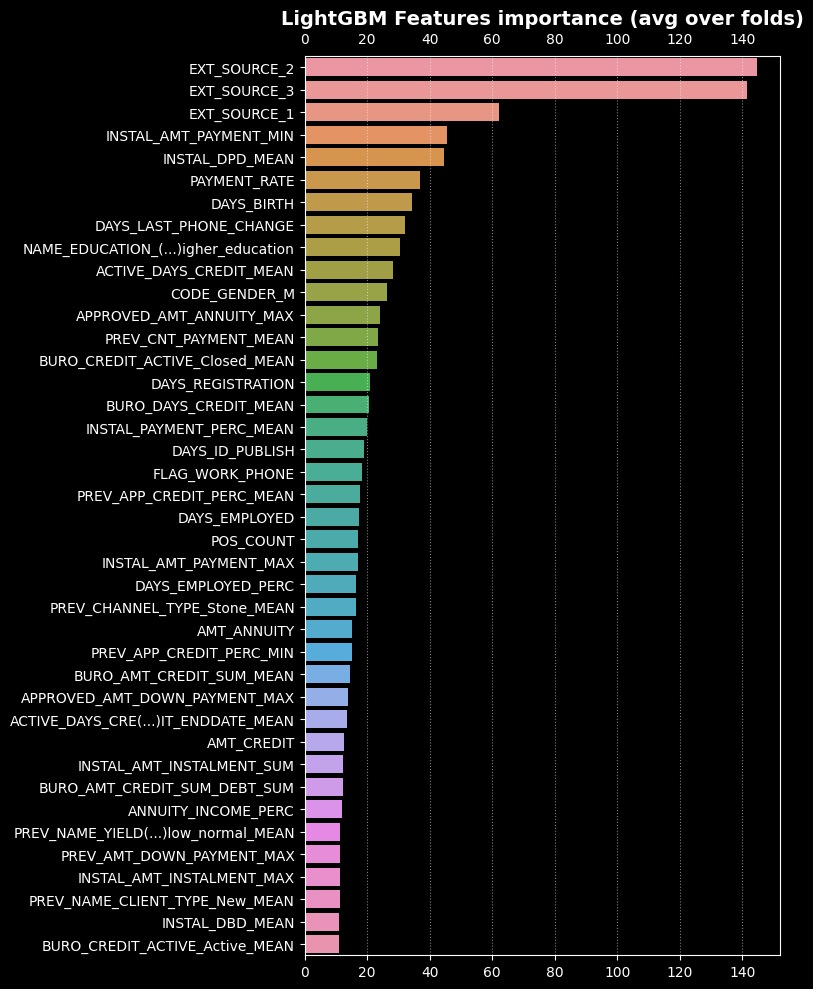

In [ ]:
from home_credit.kernel import display_importances
selected_best_feats = display_importances(feat_imps)

## Scores par pli et globaux

In [ ]:
display(scores)

{'F2': {'over_folds': [0.0,
   0.019230769230769232,
   0.008787346221441126,
   0.0,
   0.0],
  'overall': 0.005472455308281649},
 'AUC': {'over_folds': [0.7307598897762831,
   0.7596071442483737,
   0.7506489220312376,
   0.7463495075449534,
   0.765373946002362],
  'overall': 0.7505985643315459}}

## Courbe ROC

overall AUC verif: 0.7505985643315459


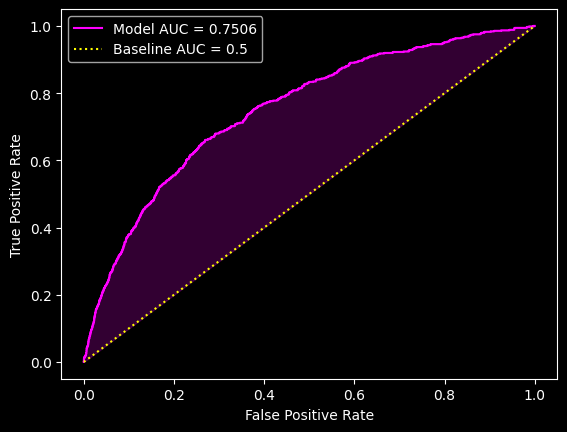

In [ ]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print(f"Overall AUC score: {roc_auc_score(y_train, train_pred_proba)}")
plot_roc_curve(y_train, train_pred_proba, overall_auc)

# Impact des pré-traitements sur les performance

## Effet du ré-échantillonage

<mark>**TODO** Faire taire les traces de LGBM si verbosity=0 (après soutenance)</mark>

### Entraînement du modèle

In [ ]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from home_credit.kernel import get_opt_lgbm_classifier

data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)
clf = get_opt_lgbm_classifier()
res = kfold_train_and_eval_model(
    data, clf, scaler=None,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


LGBMClassifier(callbacks=None, colsample_bytree=0.9497036, learning_rate=0.02,
               max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 

Resampling
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7898, -1.0: 1379, 1.0: 723})
Resampled dataset shape: Counter({1.0: 7675, -1.0: 7665, 0.0: 7568})

Train vs. test subsets shapes
	Train shape: (15243, 788)
	Test shape: (7665, 788)

Evaluate the 1-th fold (on 5)
[200]	training's binary_logloss: 0.144589	valid_1's binary_logloss: 0.18575
[400]	training's binary_logloss: 0.104959	valid_1's binary_logloss: 0.164252
[600]	training's binary_logloss: 0.0884584	valid_1's binary_logloss: 0.161597
[800]	training's binary_logloss: 0.0772599	valid_1's binary_logloss: 0.16088
[1000]	training's binary_logloss: 0.0688881	valid_1's binary_logloss: 0.160776
Fold  0 F2: 0.915981
Fold  0 AUC: 0.974638

Evaluate the 2-th fold (on 5)
[200]	training's binary_logloss: 0.148935	valid_1's binary_logloss: 0.169165
[400]	training's binary_logloss: 0.109097	valid_1's binary_logloss: 0.143482
[600]	training's binary_logloss: 0.0922306	valid_1's binary_logloss: 0.137708
[800]	training's binary_logloss: 0.0808292	valid_1's bina

### Interprétation des résultats

Avec un AUC de 0.98, il y a probablement du sur-apprentissage, ce qui n'est surprenant avec un échantillon aussi réduit.

Cela dit, l'impact du rééquilibrage des classes est manifeste.

overall AUC verif: 0.981197102836562


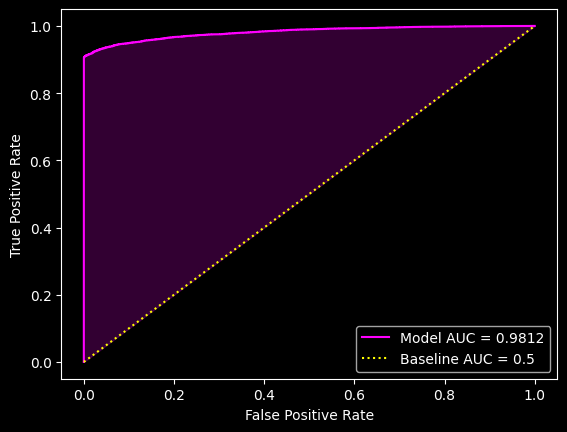

In [ ]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print(f"Overall AUC score: {roc_auc_score(y_train, train_pred_proba)}")
plot_roc_curve(y_train, train_pred_proba, overall_auc)

### Matrice de confusion


Confusion matrix


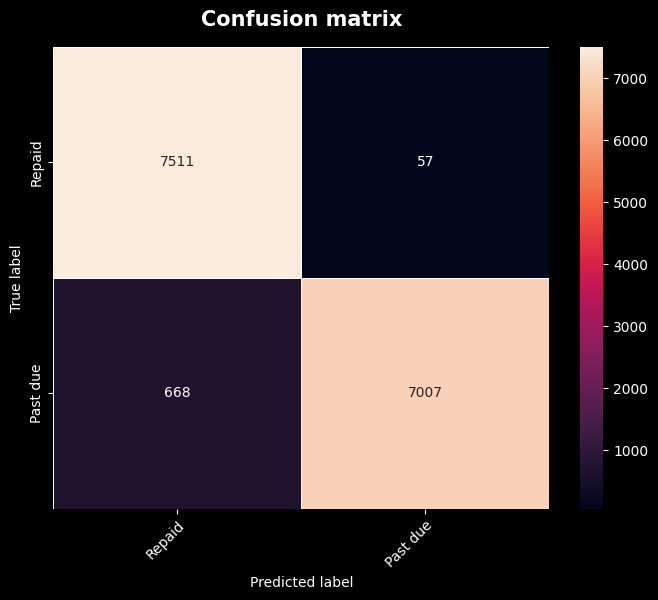

In [ ]:
from pepper.scoring import show_confusion_matrix
y_train = res["resamples"]["y_train"]
train_pred_discr = res["preds"]["train"]["discr"]
show_confusion_matrix(y_train, train_pred_discr, ["Repaid", "Past due"])

### Importance des caractéristiques

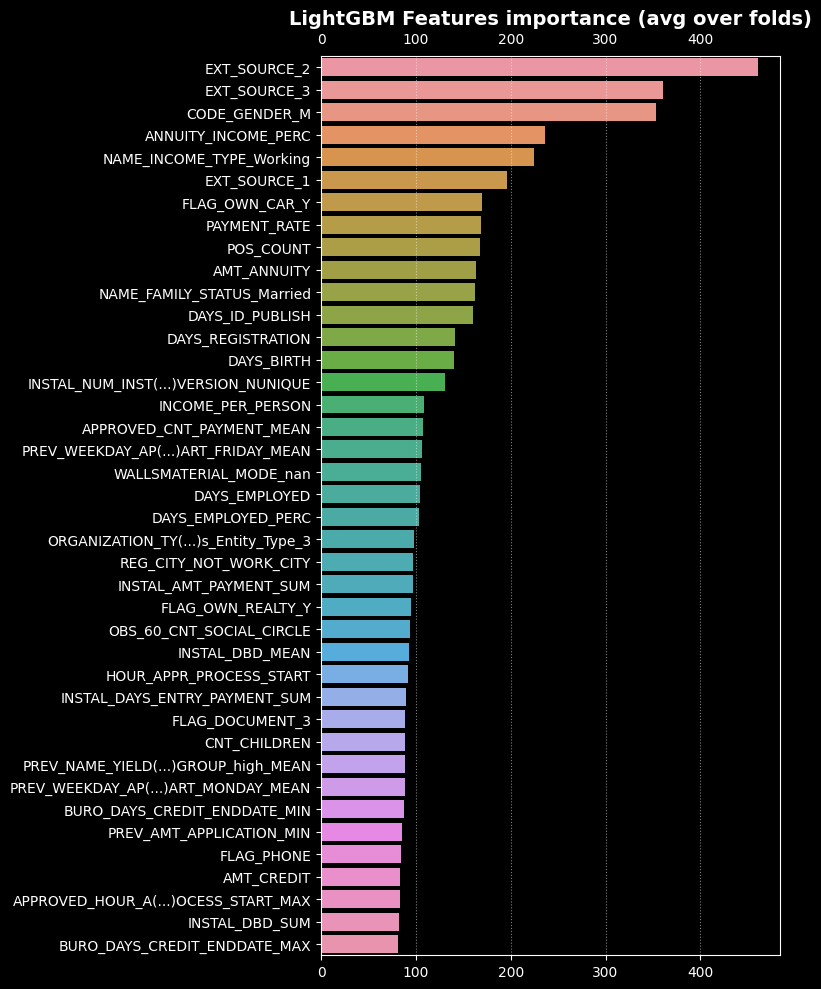

In [ ]:
from home_credit.kernel import display_importances
feat_imps = res["feat_imps"]
selected_best_feats = display_importances(feat_imps)

## Effet de la mise à l'échelle

### Entraînement du modèle

In [ ]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model
from home_credit.kernel import get_opt_lgbm_classifier

data = load_prep_dataset("baseline_v1")
data = data.sample(10_000)
clf = get_opt_lgbm_classifier()
res = kfold_train_and_eval_model(
    data, clf,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


LGBMClassifier(callbacks=None, colsample_bytree=0.9497036, learning_rate=0.02,
               max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y_valid, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 

Resampling
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 7975, -1.0: 1351, 1.0: 674})
Resampled dataset shape: Counter({1.0: 7763, -1.0: 7715, 0.0: 7649})

Train vs. test subsets shapes
	Train shape: (15412, 788)
	Test shape: (7715, 788)

Evaluate the 1-th fold (on 5)
[200]	training's binary_logloss: 0.136921	valid_1's binary_logloss: 0.167385
[400]	training's binary_logloss: 0.0999356	valid_1's binary_logloss: 0.145967
[600]	training's binary_logloss: 0.0838234	valid_1's binary_logloss: 0.142088
[800]	training's binary_logloss: 0.0730306	valid_1's binary_logloss: 0.1403
[1000]	training's binary_logloss: 0.0650174	valid_1's binary_logloss: 0.139803
[1200]	training's binary_logloss: 0.0588551	valid_1's binary_logloss: 0.13964
Fold  0 F2: 0.926587
Fold  0 AUC: 0.980849

Evaluate the 2-th fold (on 5)
[200]	training's binary_logloss: 0.138072	valid_1's binary_logloss: 0.160322
[400]	training's binary_logloss: 0.10187	valid_1's binary_logloss: 0.136074
[600]	training's binary_logloss: 0.0859553	valid_1's bina

### Interprétation des résultats

overall AUC verif: 0.9822982186560667


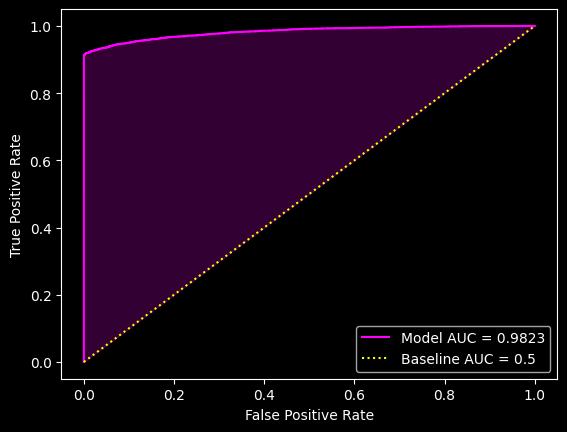

In [ ]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score
y_train = res["resamples"]["y_train"]
train_pred_proba = res["preds"]["train"]["proba"]
overall_auc = res["scores"]['AUC']['overall']
print(f"Overall AUC score {roc_auc_score(y_train, train_pred_proba)}")
plot_roc_curve(y_train, train_pred_proba, overall_auc)

### Matrice de confusion


Confusion matrix


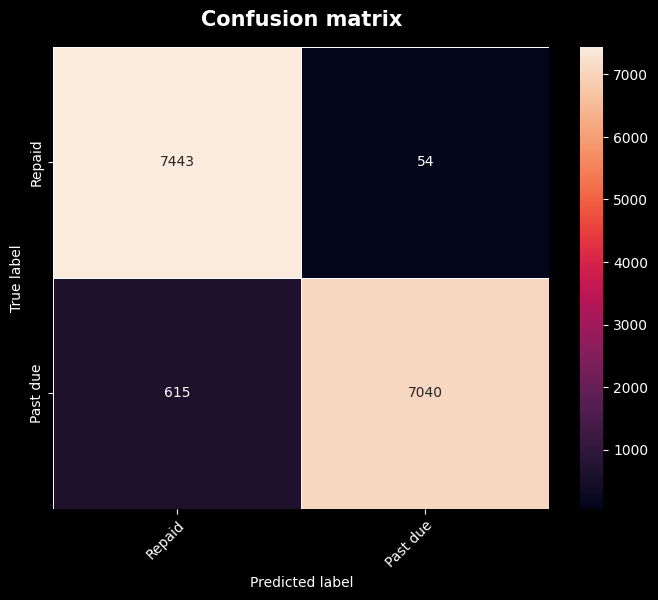

In [ ]:
from pepper.scoring import show_confusion_matrix
y_train = res["resamples"]["y_train"]
train_pred_discr = res["preds"]["train"]["discr"]
show_confusion_matrix(y_train, train_pred_discr, ["Repaid", "Past due"])

### Importance des caractéristiques

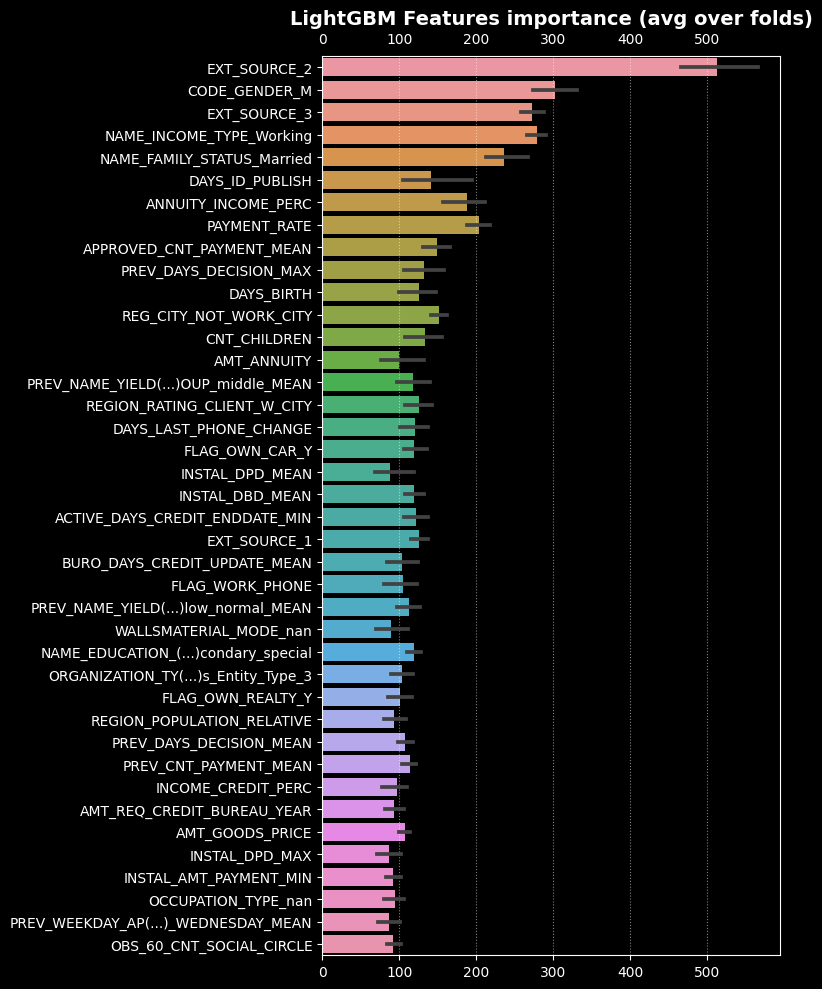

In [ ]:
from home_credit.kernel import display_importances
feat_imps = res["feat_imps"]
selected_best_feats = display_importances(feat_imps)

# **_Trash_me** **`kfold_train_and_eval_model v2`**

A la réflexion, notre première version de `kfold_train_and_eval_model` inspirée de `kfold_lightgbm` était mal conçue.

Cette pipeline principale d'entraînement et de validation croisée recevait un jeu de données, complet ou échantillon, comportant un mix des données d'entraînement et de test, puis procédait en interne à leur séparation.

Or, cette fonction ne devrait travailler que sur les données d’entraînement (et fonc faire ses propres choix, notamment de sous-division en ensemble de validation et véritable base d'entraînement, sans aucune relation avec le jeu de test).

D'une part cela nous couvre contre tout risque de fuite de données, ou encore de biais dans les sélections de parties (par exemple le resampling ou la stratification sont actuellement pollués par la classe de cible -1 qui représente l’ensemble de test). D'autre part, cela simplifie et améliore la lisibilité du code.

**TD** en outre:
* voir ce qui est dit à la fin concernant le scoring externe par validation croisée : il faut mettre à disposition les prétraitements supplémentaires de data en amont sur passage à `fit` et `predict`du classifieur `clf` utilisé.
* Encadrement (à l'aide d'une décoration ? j'aimerais mieux) dans du tracking mlflow.


Effectuons de nouveaux tests sur l'échantillon `train_baseline_10k` :

## Entraînement du modèle

In [ ]:
from home_credit.load import load_prep_dataset
from home_credit.best_model_search import kfold_train_and_eval_model_v2
from home_credit.kernel import get_opt_lgbm_classifier

data = load_prep_dataset("train_baseline_10k")
clf = get_opt_lgbm_classifier()
res = kfold_train_and_eval_model_v2(
    data, clf,
    verbosity=3
)


Starting train and eval of:
Labeled dataset of shape: (10000, 790)
Features set of shape: (10000, 788)

With:
Classifier: 


LGBMClassifier(callbacks=None, colsample_bytree=0.9497036, learning_rate=0.02,
               max_depth=8, min_child_weight=39.3259775,
               min_split_gain=0.0222415, n_estimators=10000, n_jobs=4,
               num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294,
               subsample=0.8715623)

Loss function: 


{'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

Eval metrics: 


{'F2': <function home_credit.best_model_search.<lambda>(y, y_pred)>,
 'AUC': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

On 5 KFolds: 

Resampling
Sampler: 


SMOTETomek()

Original dataset shape: Counter({0.0: 9177, 1.0: 823})
Resampled dataset shape: Counter({0.0: 9177, 1.0: 9177})
Data shape: (18354, 788)

Evaluate the 1-th fold (on 5)
[200]	training's binary_logloss: 0.176515	valid_1's binary_logloss: 0.19434
[400]	training's binary_logloss: 0.114301	valid_1's binary_logloss: 0.142994
[600]	training's binary_logloss: 0.0937089	valid_1's binary_logloss: 0.132167
[800]	training's binary_logloss: 0.0805252	valid_1's binary_logloss: 0.127365
[1000]	training's binary_logloss: 0.0712602	valid_1's binary_logloss: 0.124706
[1200]	training's binary_logloss: 0.0637075	valid_1's binary_logloss: 0.123261
[1400]	training's binary_logloss: 0.0576747	valid_1's binary_logloss: 0.122362
[1600]	training's binary_logloss: 0.0527661	valid_1's binary_logloss: 0.121459
[1800]	training's binary_logloss: 0.0485965	valid_1's binary_logloss: 0.121037
[2000]	training's binary_logloss: 0.0451633	valid_1's binary_logloss: 0.120642
[2200]	training's binary_logloss: 0.0421364	valid

## Extraction et affichage des résultats

```Python
# Return :
#   resampled data features and target
#   probabilistic and discrete predictions (on oof valid data),
#   performance scores and feature importances
res = {
    "resamples": {"X": X,"y": y} --> simplement l'index,
    "preds": {"proba": oof_preds_proba, "discr": oof_preds_discr}, --> simplement la proba
    "scores": scores,
    "feat_imps": feat_imp
}
```

**TODO** Faire une petite fonction plus *pretty* -> `display_train_and_eval_results`

In [ ]:
from home_credit.best_model_search import display_train_and_eval_results
display_train_and_eval_results(res)

resampled X : shape (18354, 788)
classe counts (array([0., 1.]), array([9177, 9177], dtype=int64))
y_train_res_pred_proba: [0.22526752 0.07999937 0.20321403 ... 0.97651883 0.99895629 0.9985781 ]
y_train_res_pred_discr: [0. 0. 0. ... 1. 1. 1.]
preds counts (array([0., 1.]), array([9784, 8570], dtype=int64))


{'F2': {'over_folds': [0.9395635142697258,
   0.9324458136208604,
   0.9310344827586207,
   0.9353666593261398,
   0.9360705728599433],
  'overall': 0.9348911170988118},
 'AUC': {'over_folds': [0.9854953066152707,
   0.9850275513002718,
   0.982338298711044,
   0.9873420539443104,
   0.9839439751515527],
  'overall': 0.984851075008565}}

## ROC AUC

Avec un AUC de 0.98, il y a probablement du sur-apprentissage, ce qui n'est surprenant avec une échentillon aussi réduit.

Cela dit, l'impact du rééquilibrage des classes est manifeste.

overall AUC verif: 0.984851075008565


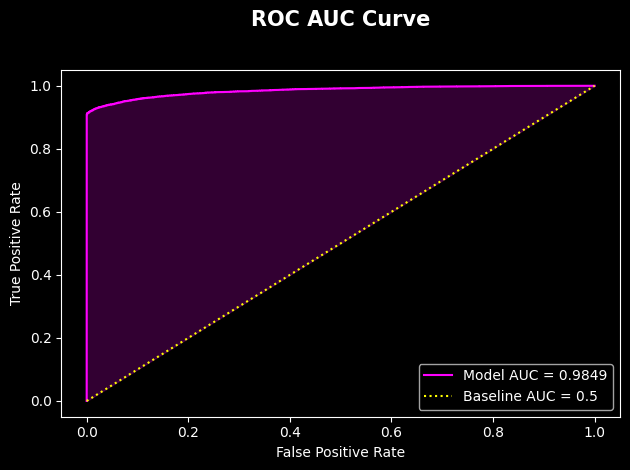

In [ ]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score

y_train_res = res["resamples"]["y"]
y_train_res_pred_proba = res["preds"]["proba"]

train_res_scores_overall_auc = res["scores"]['AUC']['overall']
print("overall AUC verif:", roc_auc_score(y_train_res, y_train_res_pred_proba))

plot_roc_curve(y_train_res, y_train_res_pred_proba, train_res_scores_overall_auc)

La même chose, sur la totalité des données d'entraînement de l'échantillon `train_baseline_10k`

C'est là que se font ressentir deux besoins essentiels:
1. de pouvoir récupérer le classifieur entraîné
2. du `train_preproc` pour rendre les données compatibles avec ce classifieur.

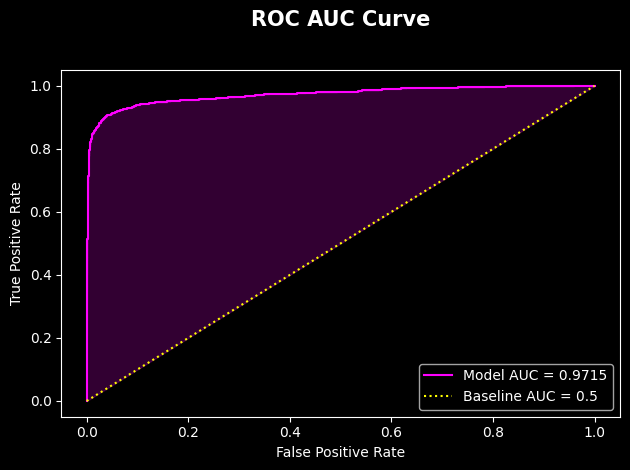

In [ ]:
from home_credit.best_model_search import plot_roc_curve
from home_credit.best_model_search import train_preproc
import sklearn as skl
from sklearn.metrics import roc_auc_score

X, y_true = train_preproc(data, skl.preprocessing.MinMaxScaler())
y_pred_proba = clf.predict_proba(X)[:, 1]
overall_auc = roc_auc_score(y_true, y_pred_proba)
plot_roc_curve(y_true, y_pred_proba, overall_auc)

Evaluation sur la totalité du jeu d'entraînement : là, on voit clairemment que, même si ce n'est pas complètement mauvais, c'est loin d'être aussi bon. Cela met en évidence le sur-apprentissage qui opérait.

array([0.6351644 , 0.12219224, 0.16275328, ..., 0.04986153, 0.04762166,
       0.25218342])

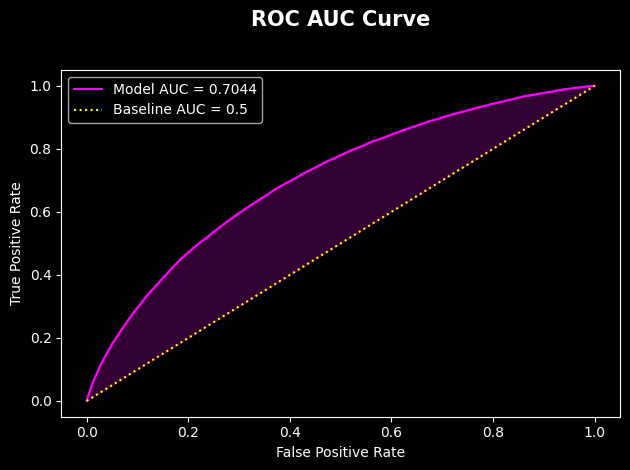

In [ ]:
from home_credit.best_model_search import plot_roc_curve
from sklearn.metrics import roc_auc_score

data_all = load_prep_dataset("train_baseline_all")
X, y_true = train_preproc(data_all, skl.preprocessing.MinMaxScaler())
y_pred_proba = clf.predict_proba(X)[:, 1]
display(y_pred_proba)
overall_auc = roc_auc_score(y_true, y_pred_proba)
plot_roc_curve(y_true, y_pred_proba, overall_auc)

Le complément de l'échantillon d'entraînement dans l'ensemble complet d'entraînement

array([0.56740325, 0.09761868, 0.1430843 , ..., 0.05720234, 0.03053151,
       0.33437433])

overall AUC verif:


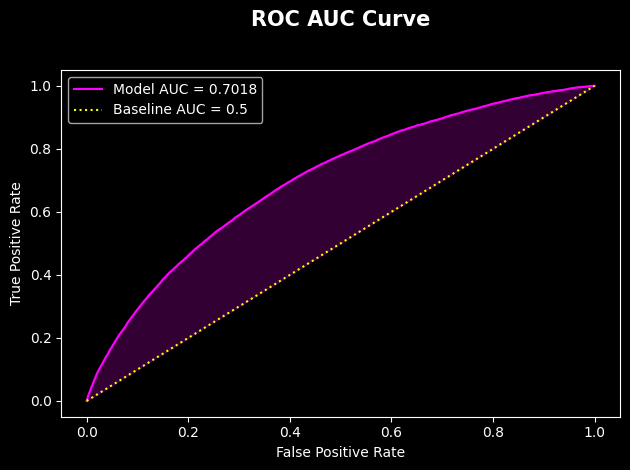

In [ ]:
data_no_train = data_all[~data_all.index.isin(data.index)]

X, y_true = train_preproc(data_no_train, skl.preprocessing.MinMaxScaler())

y_pred_proba = clf.predict_proba(X)[:, 1]
# train_pred_proba = res["preds"]["proba"]
display(y_pred_proba)

# overall_auc = res["scores"]['AUC']['overall']
overall_auc = roc_auc_score(y_true, y_pred_proba)
print("overall AUC verif:", )

plot_roc_curve(y_true, y_pred_proba, overall_auc)

## Matrice de confusion

Même approche.

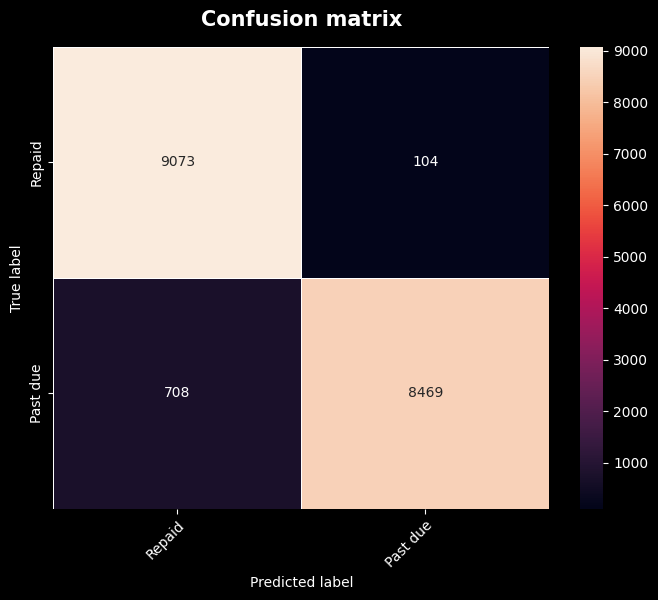

In [ ]:
from pepper.scoring import show_confusion_matrix

y_train = res["resamples"]["y"]
train_pred_discr = res["preds"]["discr"]
show_confusion_matrix(y_train, train_pred_discr, ["Repaid", "Past due"])

## Importance des caractéristiques

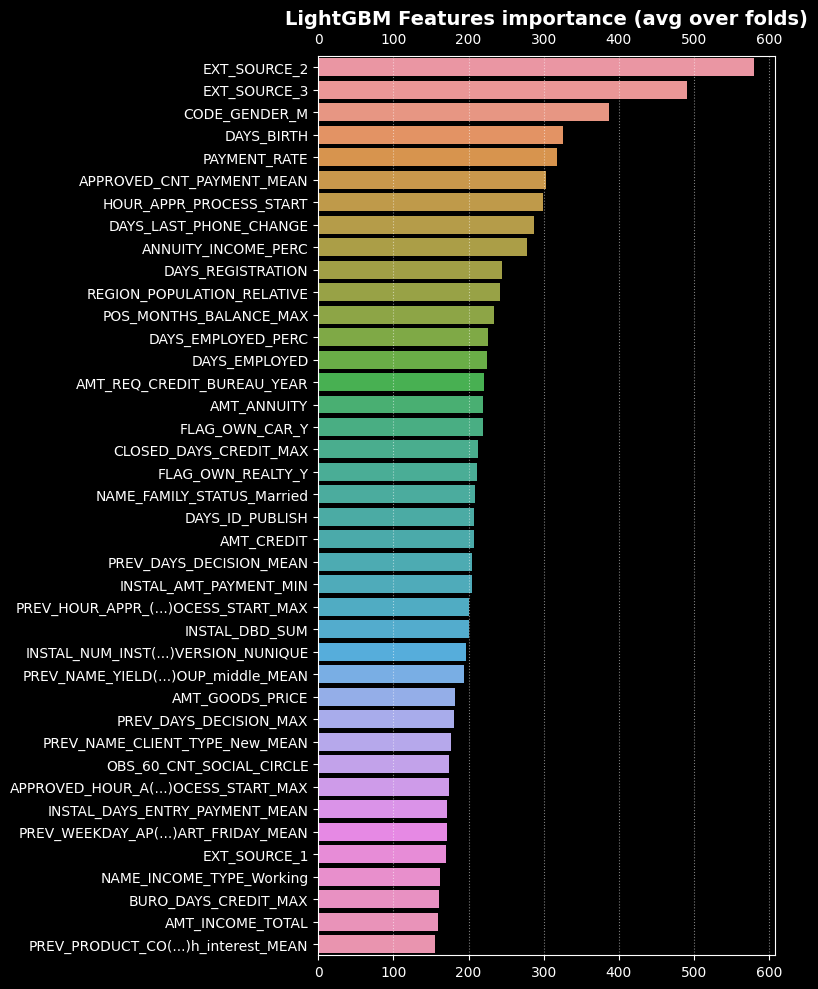

In [ ]:
from home_credit.lightgbm_kernel_v2 import display_importances
feat_imps = res["feat_imps"]
selected_best_feats = display_importances(feat_imps, "LightGBM")